In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
lines = pd.DataFrame(columns=['source','target','file_name'])




tag = []
word = []
with open('drive/MyDrive/pos-parallel-underandequal-len150') as tag_file:
    for sen in tag_file:
        """if(len(sen)>200):
            continue
        #ဗိုလ်ချုပ်/n|အောင်ဆန်း/n => ဗိုလ်ချုပ်/n အောင်ဆန်း/n
        sen = sen.strip().replace('|',' ')
        word.append(' '.join([i[:i.find('/')] for i in sen.split()]))
        tag.append(' '.join([i[i.find('/')+1:] for i in sen.split()]))
        """
        w,t = sen.split('<|||>')
        word.append(w.strip())
        tag.append(t.strip())
lines['source'] = word
lines['target'] = tag
lines.head()

In [ ]:
with open('drive/MyDrive/pos-train') as train_file:
    for sen in train_file:
        sen = sen.strip()
        w,t = sen.split('<|||>')
        lines = lines.append({'source':w,'target':t,'file_name':'train'},ignore_index=True)

with open('drive/MyDrive/pos-dev') as dev_file:
    for sen in dev_file:
        sen = sen.strip()
        w,t = sen.split('<|||>')
        lines = lines.append({'source':w,'target':t,'file_name':'dev'},ignore_index=True)

with open('drive/MyDrive/pos-test') as test_file:
    for sen in test_file:
        sen = sen.strip()
        w,t = sen.split('<|||>')
        lines = lines.append({'source':w,'target':t,'file_name':'test'},ignore_index=True)
print(lines.shape)
lines.head()


(10997, 3)


,source,target,file_name
0,အောင်ဆန်း ၏ မိခင် မျိုးရိုး ထဲ တွင် ရာထူး ကြီး...,n ppm n n ppm ppm n adj n adj v part part ppm ...,train
1,လူသား ချင်း စာနာ မှု အတွက် ဗိသုကာ ပုံစံ သည် ရေ...,n part v part ppm n n ppm adv v v part n part ...,train
2,ထို ရာသီ ကား အဿဝဏီ နက္ခတ် နှင့် ယှဉ် ၍ လပြည့် ...,adj n part n n ppm v conj n conj n part v ppm ...,train
3,၁၂ ၊ မေ ၊ ၁၇၈၃ တွင် နန်း သိမ်း ပွဲ ဖြင့် စတင် ...,num punc n punc num ppm n v n ppm v v ppm punc,train
4,စူဇူကီး သည် ဗိုလ် မိုးကြိုး ဖြစ် လာ ပြီး ၊ အော...,n ppm n n v part conj punc n ppm n n v part pp...,train


In [ ]:
dic = {}
for line in lines.target:
  for word in line.split():
    if word in dic:
      dic[word] += 1
    else:
      dic[word] = 1
df = pd.DataFrame(list(dic.items()),columns = ['tag','count'])
df

,tag,count
0,n,65007
1,ppm,38654
2,adj,7181
3,v,33469
4,part,52219
5,punc,15713
6,adv,2869
7,conj,11624
8,num,3940
9,pron,2679


In [ ]:
dic

{'abb': 311,
 'adj': 7181,
 'adv': 2869,
 'conj': 11624,
 'fw': 2296,
 'int': 98,
 'n': 65007,
 'num': 3940,
 'part': 52219,
 'ppm': 38654,
 'pron': 2679,
 'punc': 15713,
 'sb': 200,
 'tn': 2349,
 'v': 33469}

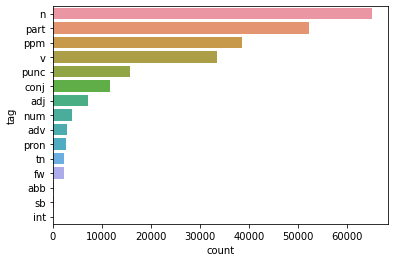

In [ ]:
sns.barplot(x='count',y='tag',data = df,order = sorted(dic,key=dic.__getitem__,reverse=True))

In [ ]:
lines.groupby('file_name').count()

,source,target
file_name,,
dev,1099,1099
test,1099,1099
train,8799,8799


In [ ]:
lines['target'] = lines['target'].apply(lambda x: 'start_ '+x+' _end')
lines['source_len'] = lines['source'].apply(lambda x: len(x.split()))
lines['target_len'] = lines['target'].apply(lambda x: len(x.split()))
lines.head()

,source,target,file_name,source_len,target_len
0,အောင်ဆန်း ၏ မိခင် မျိုးရိုး ထဲ တွင် ရာထူး ကြီး...,start_ n ppm n n ppm ppm n adj n adj v part pa...,train,15,17
1,လူသား ချင်း စာနာ မှု အတွက် ဗိသုကာ ပုံစံ သည် ရေ...,start_ n part v part ppm n n ppm adv v v part ...,train,35,37
2,ထို ရာသီ ကား အဿဝဏီ နက္ခတ် နှင့် ယှဉ် ၍ လပြည့် ...,start_ adj n part n n ppm v conj n conj n part...,train,15,17
3,၁၂ ၊ မေ ၊ ၁၇၈၃ တွင် နန်း သိမ်း ပွဲ ဖြင့် စတင် ...,start_ num punc n punc num ppm n v n ppm v v p...,train,14,16
4,စူဇူကီး သည် ဗိုလ် မိုးကြိုး ဖြစ် လာ ပြီး ၊ အော...,start_ n ppm n n v part conj punc n ppm n n v ...,train,16,18


arr = []
with open('/home/acyclic/NLP/MTRSS/pbsmt/data/train.my') as my:
    for line in my:
        arr.append(line.replace('။','').strip())
lines['source'] = arr
arr =[]
with open('/home/acyclic/NLP/MTRSS/pbsmt/data/train.rk') as rk:
    for line in rk:
        arr.append(line.replace('။','').strip())
lines['target'] = arr
lines.head()

lines['source'] = lines['source'].apply(lambda x: re.sub(r'[^က-၏]',' ',x))
lines['target'] = lines['target'].apply(lambda x: re.sub(r'[^က-၏]',' ',x))
lines.head()

lines['target'] = lines['target'].apply(lambda x: 'start_ '+x+' _end')

In [ ]:
# Find all the source and target words and sort them
# Vocabulary of Source language
all_source_words=set()
for source in lines.source:
    for word in source.split():
        if word not in all_source_words:
            all_source_words.add(word)# Vocabulary of Target 
all_target_words=set()
for target in lines.target:
    for word in target.split():
        if word not in all_target_words:
            all_target_words.add(word)
# sort all unique source and target words
source_words= sorted(list(all_source_words))
target_words=sorted(list(all_target_words))

In [ ]:
target_words

['_end',
 'abb',
 'adj',
 'adv',
 'conj',
 'fw',
 'int',
 'n',
 'num',
 'part',
 'ppm',
 'pron',
 'punc',
 'sb',
 'start_',
 'tn',
 'v']

In [ ]:
#max_source_length= max(lines['source_len'])
max_source_length = 150
print(" Max length of the source sentence",max_source_length)
#max_target_length= max(lines['target_len'])
max_target_length =150
print(" Max length of the target sentence",max_target_length)

 Max length of the source sentence 150
 Max length of the target sentence 150


In [ ]:
# creating a word to index(word2idx) for source and target
source_word2idx= dict([(word, i+1) for i,word in enumerate(source_words)])
target_word2idx=dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
#creating a dictionary for index to word for source and target vocabulary
source_idx2word= dict([(i, word) for word, i in  source_word2idx.items()])
#print(source_idx2word)
target_idx2word =dict([(i, word) for word, i in target_word2idx.items()])

In [ ]:
# Train - Test Split
#X, y = lines.source, lines.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:

X_train = lines.loc[lines['file_name']=='train','source']
y_train = lines.loc[lines['file_name']=='train','target']

X_dev = lines.loc[lines['file_name']=='dev','source']
y_dev = lines.loc[lines['file_name']=='dev','target']

X_test = lines.loc[lines['file_name']=='test','source']
y_test = lines.loc[lines['file_name']=='test','target']
X_train.shape, X_dev.shape


((8799,), (1099,))

In [ ]:
X_dev

8799    “ ကုလား တို့ ကျွန် မ ခံ ” ဟူသော စိတ်ထား ရှိ ခဲ...
8800     အဲဒါ က လေးဆယ့်ငါး လမ်း မှာ ဟုတ် တယ် မ ဟုတ် လား ။
8801    ပုပ်ရဟန်းမင်းကြီး က ဂယ်လီလီယို ကို သူ ၏ ဘဝ အချ...
8802                                      ဘေးဖယ် နေ မယ် ။
8803    ပထမ မှာ သားရေ ပေါ် တွင် ကပ် ၍ ပေါက် သော အမွေး ...
                              ...                        
9893    ဤ အမည် မှာ ၁၉၄၈ ခုနှစ် မ တိုင် မီ က ဗြိတိသျှ မ...
9894    ပထမ ဒြပ်ပေါင်း တွင် နိုက်ထရိုဂျင် အလေးချိန် ၇ ...
9895    အသောက မင်း ကဲ့သို့ ပင် သာသနာ ပြန့်ပွား ထွန်းကာ...
9896    ကမ္ဘာ ပေါ် ရှိ ဒေသ များ နှင့် နိုင်ငံ အစုအဝေး ...
9897    ခရီးဆောင် အိတ် က အဲဒီ ကို ရောက် မှာ နော် ၊ ဟုတ...
Name: source, Length: 1099, dtype: object

In [ ]:
type(X_test)

pandas.core.series.Series

In [ ]:
# Input tokens for encoder
num_encoder_tokens=len(source_words)+1
# Input tokens for decoder zero padded
num_decoder_tokens=len(target_words) +1
print(num_encoder_tokens,num_decoder_tokens)

15845 18


In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                  encoder_input_data[i, t] = source_word2idx[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_word2idx[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, target_word2idx[word]] = 1.
            #print(encoder_input_data.shape,decoder_input_data.shape,decoder_targer_data.shape)
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
train_samples = len(X_train)
val_samples = len(X_dev)
batch_size = 128
epochs = 50
latent_dim=500

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
print(decoder_outputs.shape)


decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)

(None, None, 500)
(None, None, 18)


In [ ]:
# Define the model that takes encoder and decoder input 
# to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:

#tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
train_samples = len(X_train) # Total Training samples
val_samples = len(X_dev)    # Total validation or test samples
batch_size = 128
epochs = 100

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_dev, y_dev, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


68/68 [==============================] - 18s 151ms/step - loss: 0.3191 - accuracy: 0.3321 - val_loss: 0.2386 - val_accuracy: 0.4726
Epoch 2/100
68/68 [==============================] - 8s 115ms/step - loss: 0.2239 - accuracy: 0.4772 - val_loss: 0.2254 - val_accuracy: 0.4972
Epoch 3/100
68/68 [==============================] - 8s 123ms/step - loss: 0.2099 - accuracy: 0.5089 - val_loss: 0.2108 - val_accuracy: 0.5276
Epoch 4/100
68/68 [==============================] - 8s 122ms/step - loss: 0.2007 - accuracy: 0.5290 - val_loss: 0.2033 - val_accuracy: 0.5373
Epoch 5/100
68/68 [==============================] - 9s 127ms/step - loss: 0.1935 - accuracy: 0.5499 - val_loss: 0.1952 - val_accuracy: 0.5605
Epoch 6/100
68/68 [==============================] - 9s 128ms/step - loss: 0.1853 - accuracy: 0.5713 - val_loss: 0.1900 - val_accuracy: 0.5729
Epoch 7/100
68/68 [==============================] - 9s 126ms/step - loss: 0.1776 - accuracy: 0.5885 - val_loss: 0.1824 - val_accuracy: 0.5920
Epoch 8/10

In [ ]:
model.save_weights('nmt_weights_100epochs.h5')

In [ ]:
model.load_weights('nmt_weights_100epochs.h5')

In [ ]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = target_word2idx['start_']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
        #print(sampled_word)
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_end' or len(decoded_sentence) > max_target_length):
            stop_condition = True
            # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
i=-1

In [ ]:
i+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_train[i:i+1].values[0])
print('Actual Target Translation:', y_train[i:i+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])
#print(input_seq, actual_output)

Input Source sentence: အောင်ဆန်း ၏ မိခင် မျိုးရိုး ထဲ တွင် ရာထူး ကြီး မင်းမှုထမ်း အချို့ ပါဝင် ခဲ့ ပါ သည် ။
Actual Target Translation:  n ppm n n ppm ppm n adj n adj v part part ppm punc 
Predicted Target Translation:  n ppm n n ppm ppm n adj n adj v part part ppm punc 


In [ ]:
dev_gen = generate_batch(X_dev,y_dev,batch_size=1)

dev_set = pd.DataFrame(columns=['source','ref','hyp'])
for k in range(len(X_dev)):
  if(k%100==0):
    print(k)
  (input_seq, actual_output),_ = next(dev_gen)
  decoded_sentence = decode_sequence(input_seq)
  dev_set = dev_set.append({'source':X_dev[k:k+1].values[0],
                            'ref':y_dev[k:k+1].values[0][6:-4],
                            'hyp':decoded_sentence[:-4]},ignore_index = True)
  """print('Input Source sentence:', X_dev[k:k+1].values[0])
  print('Actual Target Translation:', y_dev[k:k+1].values[0][6:-4])
  print('Predicted Target Translation:', decoded_sentence[:-4])
  print()"""
dev_set.head()

In [ ]:
dev_set.to_csv('THN_dev_set.csv')

In [ ]:
dev_BLEU

In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1


In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)

test_set = pd.DataFrame(columns=['source','ref','hyp'])
for k in range(len(X_test)):
  if(k%100==0):
    print(k)
  (input_seq, actual_output),_ = next(test_gen)
  decoded_sentence = decode_sequence(input_seq)
  test_set = test_set.append({'source':X_test[k:k+1].values[0],
                            'ref':y_test[k:k+1].values[0][6:-4],
                            'hyp':decoded_sentence[:-4]},ignore_index = True)
  """print('Input Source sentence:', X_dev[k:k+1].values[0])
  print('Actual Target Translation:', y_dev[k:k+1].values[0][6:-4])
  print('Predicted Target Translation:', decoded_sentence[:-4])
  print()"""
test_set.head()
test_set.to_csv("THN_test_set.csv")